In [89]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import pandas as pd

In [90]:
#data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
#the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df = pd.read_csv('data_interest_rate.csv')
df2 = df.drop([df.index[120]])
df3 = df2["interest_rate"]
df3

df_inflation = pd.read_csv('inflation_data_real.csv')
df_inflation = df_inflation['Value2']
df_inflation

#global variables

HOUSE_SIZES = ["XS", "S", "M", "L", "XL"]
# location miss veranderen voor staten en evt met dict en kans/ verhouding inwoners erbij -> geen idee hoe.
LOCATIONS_earlier = ["N", "E", "S", "W"]

INTEREST_RATE = list(df3)
INFLATON = list(df_inflation)

# scratch
# for location the following can maybe be used (comes from https://gist.github.com/JeffPaine/3083347):
west = ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT"]
midwest = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
southwest = ["AZ", "NM", "TX", "OK"]
southeast = ["AR", "LA", "MS", "TN", "AL", "KY", "GA", "WV", "VA", "NC", "SC", "FL", "MD", "DE"]
northeast = ["CT", "DC", "HI", "ME", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
noncontig = ["HI", "AK"]

#other option:
LOCATIONS = ["Urban", "Suburban", "Rural"]


**Plan:**

  Echte situatie van een jaar of 10 proberen te maken.

  Vervolgens die situatie gebruiken om interest rates aan te passen. 

**Hoe?**

  Duidelijke regels hebben voor koop en verkoop.

  Uitbreiden met bijvoorbeeld locatie, type huis, grote huis -> kan miss met score voor voorkeur.

  Hoeveelheid kopers en verkopers kan impact hebben op kosten van huis.
  
  
ONTHOUDEN:
      Wellicht aparte lijsten/ arrays maken van current listings en verkochte/ gekochte agents!!!!

In [353]:
class BuyerAgent(Agent):
    def __init__(self, model, interest_rate, inflation, bool_bought, mean_salary):
        #super().__init__(model)

        # assumption people are willing to pay between 30 and 50 % of salary. -> no source yet
        interest_rate_monthly = interest_rate / 100 / 12
        
        #Us avarage of percentage to mortage in US is 25 - 30 % -> no source yet
        mean_percentage = 0.275
        std_percentage = 0.25
        willing_to_pay = np.clip(np.random.normal(mean_percentage, std_percentage), 0.1, 1)
        
        #assumption paying mortage in 30 years. 30 * 12 = 360 payments.
        payments = 360
        std_dev_salary = 1000 #maybe add inflation and growth here too
        #np.clip only gives numbers between the two given numbers, in this case 1000 and 20000
        self.salary = np.clip(np.random.normal(mean_salary, std_dev_salary), 1000.0, 20000.0)

        
        # M = P * (r * (1 + r)^360) / ((1 + r)^360 - 1) based on https://www.bankrate.com/mortgages/mortgage-calculator/#calculate-mortgage-payment
        # P is principal loan amount, M is monthly payment (here max monthly payment) and r = interest rate monthly
        # Omgerekend = P = M / (r * (1 + r)^360) / ((1 + r)^360 - 1)
        M = self.salary * willing_to_pay
        self.budget = (M * ((1 + interest_rate_monthly)**payments - 1)) / (interest_rate_monthly * (1 + interest_rate_monthly)**payments)

        self.preference_size = np.random.choice(HOUSE_SIZES)
        self.preference_location = np.random.choice(LOCATIONS)

        #variables to keep track of information
        self.months = 0
        self.house_bought = bool_bought

    def buy_house(self, model):
        """Function that buys a house"""
        if self.house_bought == False:
            sellers = model.Seller_Agents #[seller for seller in model.Seller_Agents if not seller.house_sold]
            affordable_sellers = [seller for seller in sellers if seller.cost <= self.budget]
            if not affordable_sellers:
                return
            # a house is for sure sold if the location and preference and size and preference are the same. Als the budget doesn't differ more than 100000
            perfect_combos = [seller for seller in affordable_sellers if seller.location == self.preference_location and
                             seller.house_size == self.preference_size and abs(seller.cost - self.budget) <= 20000]
            
            #if perfect_combos and np.random.rand() > 0.1:
            if perfect_combos:
                chosen_seller = np.random.choice(perfect_combos)
                model.sales_this_month.append(chosen_seller.cost)
                model.existing_houses.append(chosen_seller)
                chosen_seller.months = 0
                model.Seller_Agents.remove(chosen_seller)
                model.Buyer_Agents.remove(self)
                if self in model.Buyer_Agents:
                    print("Something went wrong")
                #self.house_bought = True
                #chosen_seller.house_sold = True
                
            else:
                alright_combos = [seller for seller in affordable_sellers if abs(LOCATIONS.index(seller.location) - LOCATIONS.index(self.preference_location)) <= 1 and 
                                    abs(HOUSE_SIZES.index(seller.house_size) - HOUSE_SIZES.index(self.preference_size)) <= 1 and abs(seller.cost - self.budget) <= 20000.0]
                
                if alright_combos and np.random.rand() < 0.334:
                    #only 50 % chance on buying
                    chosen_seller = np.random.choice(alright_combos)
                    model.sales_this_month.append(chosen_seller.cost)
                    model.existing_houses.append(chosen_seller)
                    chosen_seller.months = 0
                    model.Seller_Agents.remove(chosen_seller)
                    model.Buyer_Agents.remove(self)

                #small change a buyer buys something not well fit
                elif affordable_sellers and np.random.rand() > 0.01:
                    chosen_seller = np.random.choice(affordable_sellers)
                    model.sales_this_month.append(chosen_seller.cost)
                    model.existing_houses.append(chosen_seller)
                    chosen_seller.months = 0
                    model.Seller_Agents.remove(chosen_seller)
                    model.Buyer_Agents.remove(self)

class SellerAgent(Agent):
    def __init__(self, model, inflation, bool_sold, mean_cost):
        #super().__init__(model)
        std_cost = mean_cost / 3
        self.cost = np.clip((np.random.normal(mean_cost, std_cost)), 100000, 2000000)
        self.orig_cost = self.cost
        self.house_sold = bool_sold
        self.house_size = np.random.choice(HOUSE_SIZES)
        self.location = np.random.choice(LOCATIONS)
        self.months = 0

    def change_cost(self, model):
        demand_supply_ratio = len(model.Buyer_Agents) / max(1, len(model.Seller_Agents))
        base_growth = 0.03  # Base monthly growth
        growth_multiplier = min(1, demand_supply_ratio)  # Cap the multiplier
        if demand_supply_ratio > 1:
            self.cost *= (1 + base_growth * growth_multiplier)
        
        # Adjust downward if unsold for too long
        if self.months > 1 and self.cost > self.orig_cost * 0.6:
            self.cost *= 0.95

class House_Model(Model):
    def __init__(self, number_of_buyers, number_of_sellers, interest_rate, seed=None):
        super().__init__(seed=seed)
        self.num_buyers = 0
        self.num_sellers = 0
        self.interest_rate = interest_rate
        self.historice_growth_month = 0.05 / 12 #maybe use historic data/ real data
        self.inflation = 1
        self.num_sold = 0
        self.month = 1
        #mean_salary = 4354
        #self.Buyer_Agents = [BuyerAgent(self, self.interest_rate, self.inflation, True, mean_salary) for _ in range(self.num_buyers)]
        self.Buyer_Agents = []
        #creation of houses already in posession
        mean_cost = 310000
        self.existing_houses = [SellerAgent(self, self.inflation, bool_sold = True, mean_cost = mean_cost) for _ in range(self.num_sellers)]
        self.Seller_Agents = []

        # Data collector
        self.Mean_Sale_Prices = []
        self.Unsold_houses = []
        self.Number_of_buyers = []
        self.Number_of_houses_sold = []
        self.sales_this_month = []
        for buyer in self.Buyer_Agents:
            buyer.buy_house(self)

    def step(self, monthly_interest_rate, inflation):
        self.sales_this_month = []
        self.inflation *= (1 + inflation / 100)
        #print(f"inflation = {self.inflation}")
        self.use_inflation(inflation)
        self.interest_rate = monthly_interest_rate
        self.add_agents_per_step()
        self.bought_to_sell()
        np.random.shuffle(self.Seller_Agents)
        for seller in self.Seller_Agents:
            seller.change_cost(self)
        np.random.shuffle(self.Buyer_Agents)
        for buyer in self.Buyer_Agents:
            buyer.buy_house(self)
        self.reset_num_agents()
        self.collect_data()
        self.num_sold += len(self.sales_this_month)
        self.month += 1

        # print(f"Turn {self.month}: Buyers={len(self.Buyer_Agents)}, Sellers={len(self.Seller_Agents)}, Demand/Supply={len(self.Buyer_Agents) / max(1, len(self.Seller_Agents))}")
        # print(f"Inflation Factor: {(1 + inflation) * (1 + self.historice_growth_month)}")
        # print(f"Average Buyer Budget: {np.mean([buyer.budget for buyer in self.Buyer_Agents])}")
        # print(f"Mean Sale Price: {self.Mean_Sale_Prices[-1] if self.Mean_Sale_Prices else 0}")


    def collect_data(self):
        self.Mean_Sale_Prices.append(self.compute_mean_house_price())
        if self.Mean_Sale_Prices[-1] == 0 and len(self.Mean_Sale_Prices) > 1:
            self.Mean_Sale_Prices[-1] = self.Mean_Sale_Prices[-2]
        self.Unsold_houses.append(self.compute_unsold_inventory())
        self.Number_of_buyers.append(self.compute_num_house_buyers())
        self.Number_of_houses_sold.append(self.compute_num_sold())
    
    def compute_mean_house_price(self):
        if len(self.sales_this_month) > 0:
            return np.mean(self.sales_this_month)  
        else:
            return 0

    def compute_unsold_inventory(self):
        return len(self.Seller_Agents)
        #return len([1 for agent in self.Seller_Agents if not agent.house_sold])

    def compute_num_house_buyers(self):
        return len(self.Buyer_Agents)
        #return len([1 for agent in self.Buyer_Agents if not agent.house_bought])
    
    def compute_num_sold(self):
        return len(self.sales_this_month)
    
    def reset_num_agents(self):
        self.num_buyers = self.num_buyers - len(self.sales_this_month)
        self.num_sellers = self.num_sellers - len(self.sales_this_month)
    
    def use_inflation(self, inp_inflation):
        """Vectorized inflation and growth updates for agents."""
        inflation_factor = (1 + inp_inflation / 100) * (1 + self.historice_growth_month)
        buyer_salaries = np.array([buyer.salary for buyer in self.Buyer_Agents])
        buyer_salaries *= inflation_factor
        for buyer, salary in zip(self.Buyer_Agents, buyer_salaries):
            buyer.salary = int(salary)
            buyer.months += 1

        seller_costs = np.array([seller.cost for seller in self.Seller_Agents])
        seller_costs *= inflation_factor
        for seller, cost in zip(self.Seller_Agents, seller_costs):
            seller.cost = int(cost)
            seller.months += 1

        existing_costs = np.array([house.cost for house in self.existing_houses])
        existing_costs *= inflation_factor
        for house, cost in zip(self.existing_houses, existing_costs):
            house.cost = int(cost)

    def add_agents_per_step(self):
        num_extra_buyers = 105 # baseren op groei bevolking
        num_extra_sellers = 100 #max(80, int(40 * (3 - self.interest_rate)))
        #during the corona period the supply of new houses went down.
        if self.month >= 90 and self.month <= 105:
            num_extra_sellers = int( num_extra_sellers * 0.5)
 
        mean_salary = (4354 * (1 + self.inflation / 100)) * (1 + self.historice_growth_month) ** self.month
        
        new_Buyer_Agents = [BuyerAgent(self, self.interest_rate, self.inflation, False, mean_salary) for _ in range(num_extra_buyers)]
        self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents
        #num_extra_sellers moet nog ergens op gebaseert worden-> gedachte nu: hogere interest rates = duurder lenen = minder huizen gebouwd.
        #Daardoor nu een staandaard/ base rate gepakt en vervolgens op basis van interest rate er iets van af halen of bij optellen 
        
        mean_cost = 310000 * (1 + self.inflation / 100) * (1 + self.historice_growth_month) ** self.month
        
        new_Seller_Agents =  [SellerAgent(self, self.inflation, bool_sold = False, mean_cost = mean_cost) for _ in range(num_extra_sellers)]
        self.Seller_Agents = self.Seller_Agents + new_Seller_Agents
        
        self.num_buyers += num_extra_buyers
        self.num_sellers += num_extra_sellers

    def bought_to_sell(self):
        """Function makes people that once bought a house a seller
        
        HIER MOET NOG DATA VOOR GEVONDEN WORDEN!
            -> Met deze functie kan add_agents_per_step worden veranderd in alleen nieuwe huizen die op de markt komen.

            OOK MOET ER VOOR HET MODEL START AL AGENTS AANGEMAAKT WORDEN DIE AL EEN HUIS HEBBEN.
            WELLICHT OOK PER VERKOOP EXTRA KOPER?

        https://www.census.gov/construction/nrc/pdf/newresconst.pdf and https://ceramicworldweb.com/en/economics-and-markets/another-difficult-year-us-housing-market#:~:text=In%202023%20the%20U.S.%20residential,also%20for%20the%20year%202024. 
        -> aproxamaly 1.4 mil new houses
        122.4 mil households in 2013
        so approx 4 mil houses are resold each year (based on house_sold_2014-2023 png)
        4 / 122.4 =  3,3 % resold
        """
        #house_owner = [agent for agent in self.Seller_Agents if agent.house_sold]
        procent_of_people_selling = 0.033 / 12
        num_new_seller = int(procent_of_people_selling * len(self.existing_houses) + 0.5)
        self.num_sellers += num_new_seller
        for _ in range(num_new_seller):
            new_seller = np.random.choice(self.existing_houses)
            self.Seller_Agents.append(new_seller)
            self.existing_houses.remove(new_seller)
        
        mean_salary = int(4354 * (1 + self.inflation / 100)) * (1 + self.historice_growth_month) ** self.month
        
        new_Buyer_Agents = [BuyerAgent(self, self.interest_rate, self.inflation, False, mean_salary) for _ in range(num_new_seller)]
        self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents

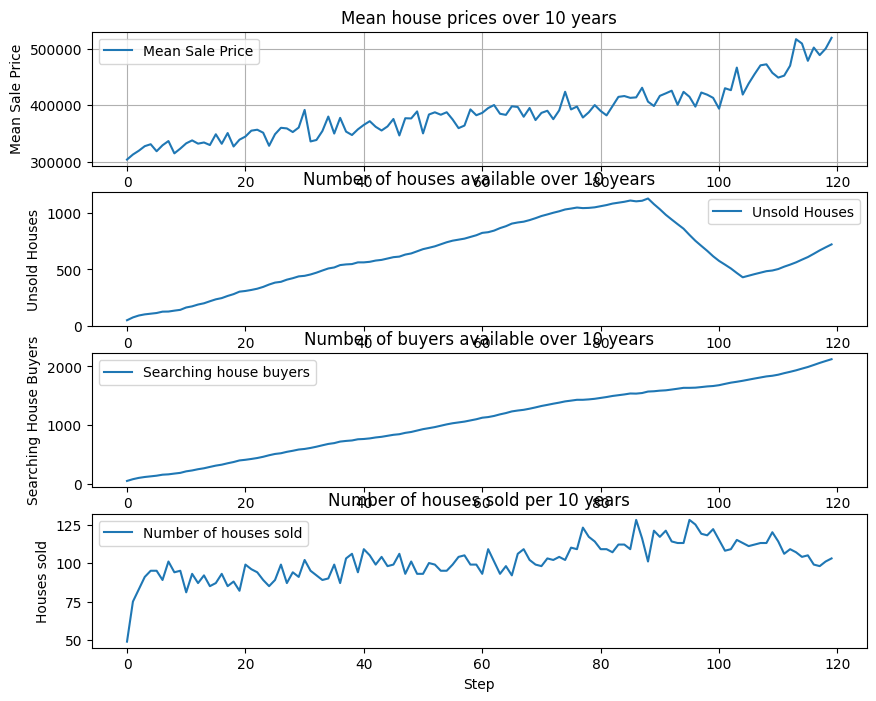

In [354]:
model = House_Model(number_of_buyers = 0, number_of_sellers = 5000, seed = None, interest_rate = INTEREST_RATE[0])

for i in range(10*12):
    #print("check", i)
    model.step(monthly_interest_rate = INTEREST_RATE[i], inflation = INFLATON[i] / 12)

results = [model.Mean_Sale_Prices, model.Unsold_houses, model.Number_of_buyers, model.Number_of_houses_sold]

plt.figure(figsize = (10, 8))

plt.subplot(411)
plt.plot(results[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.legend()

plt.subplot(412)
plt.title("Number of houses available over 10 years")
plt.plot(results[1], label = 'Unsold Houses')
plt.xlabel('Step')
plt.ylabel('Unsold Houses')
plt.legend()

plt.subplot(413)
plt.title("Number of buyers available over 10 years")
plt.plot(results[2], label = 'Searching house buyers')
plt.xlabel('Step')
plt.ylabel('Searching House Buyers')
plt.legend()

plt.subplot(414)
plt.title("Number of houses sold per 10 years")
plt.plot(results[3], label = 'Number of houses sold')
plt.xlabel('Step')
plt.ylabel('Houses sold')
plt.legend()

plt.show()

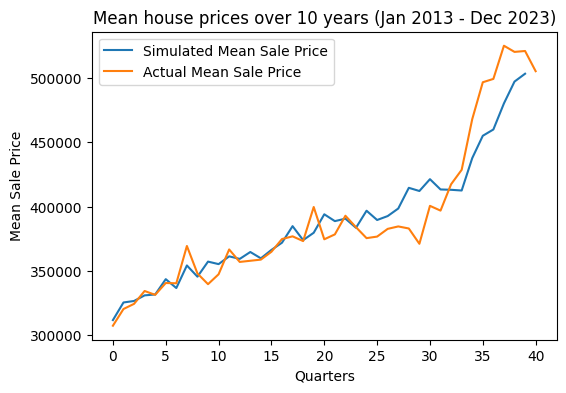

In [355]:
plt.figure(figsize = (6, 4))

controle = pd.read_csv("AVG_house_price.csv")
controle2 = controle["ASPUS"]

ds_results = []
sum = 0
for i in range(len(results[0])):
    sum += results[0][i]
    if (i + 1) % 3 == 0:
        ds_results.append(sum / 3)
        sum = 0

plt.plot(ds_results, label = 'Simulated Mean Sale Price')
plt.plot(controle2, label = 'Actual Mean Sale Price')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2023)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

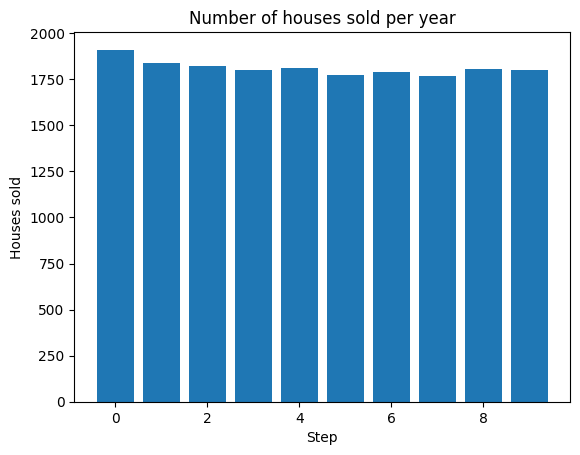

In [54]:
#bar plot for number of houses sold

house_sold_per_year = [0 for _ in range(10)]
for i in range(10):
    for j in range(12):
        house_sold_per_year[i] += results['Number of houses sold'][(i + 1) * j] 

plt.bar([i for i in range(10)], house_sold_per_year)
plt.title("Number of houses sold per year")
plt.xlabel('Step')
plt.ylabel('Houses sold')
plt.show()
plt.close()

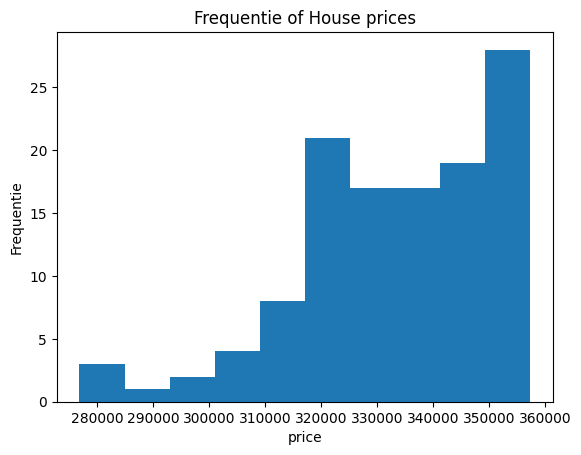

In [17]:
plt.hist(results['Mean Sale Price'])
plt.title("Frequentie of House prices")
plt.xlabel("price")
plt.ylabel("Frequentie")
plt.show()
plt.close()

Real data graphs are below

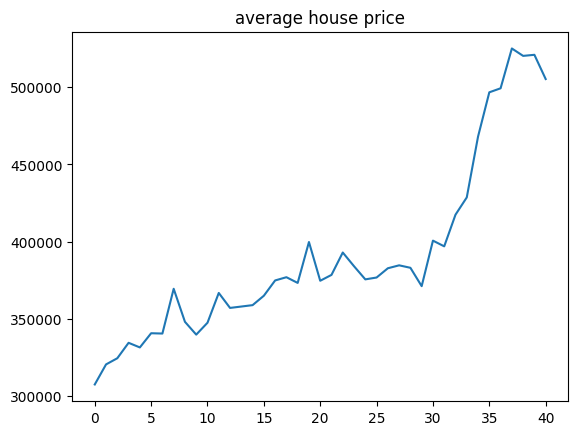

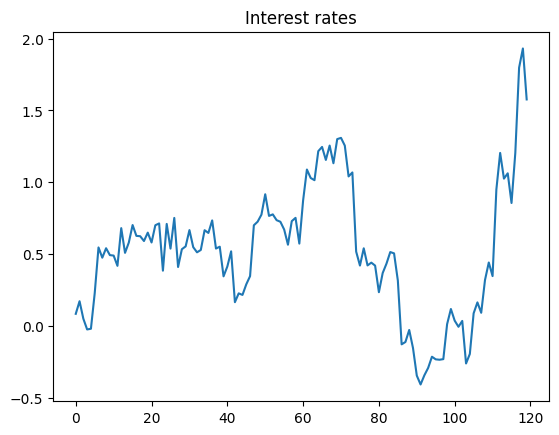

In [73]:
#check
controle = pd.read_csv("AVG_house_price.csv")
controle2 = controle["ASPUS"]
plt.plot(controle2)
plt.title("average house price")
plt.show()
plt.close()
plt.plot(df3)
plt.title("Interest rates")
plt.show()
plt.close()

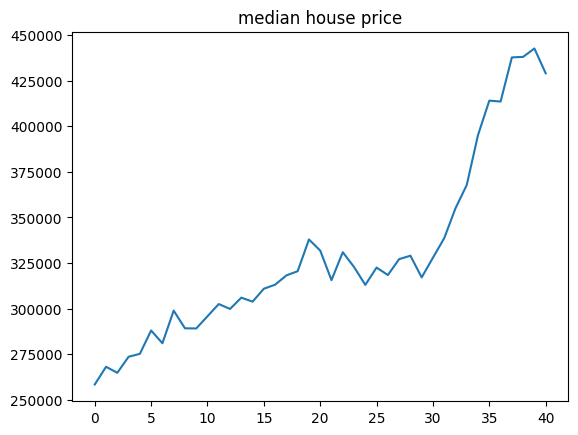

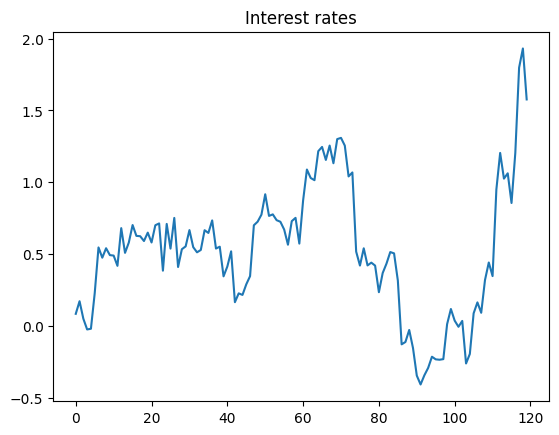

In [19]:
#check
controle = pd.read_csv("MSPUS.csv")
controle2 = controle["MSPUS"]
plt.plot(controle2)
plt.title("median house price")
plt.show()
plt.close()
plt.plot(df3)
plt.title("Interest rates")
plt.show()
plt.close()

More options:

- Agents don't always buy a house in the next time step (chance) and they have a chance to step out of the market (renting for example)
- Budget and willingness to pay is based on factors like age and family size instead of random
- Agents are able to save money (increase budget) when not buying a house
- Agents who already have a house have a chance of of selling and a chance of buying a new house
- Different kind of houses that different people have preferences for

More visualizations:

- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Histogram of house prices.